In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Color Threshold
* In order to identify colored lane lines the image is changed to HSV color-space
* Once the image is in HSV color-space, all pixels between a narrow band of colors at a set hue are filtered.
* Lane lines are white and yellow, so a filter for yellow and a filter for white are created
* The filters are combined with bitwise_or
* The filters are combined with the original image to display only the lane lines.

In [8]:
def color_mask(img):
    
    #Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = 0.75*gray #darken grayscale
    
    #Convert to HSV, take out yellow. Add white to gray image,
    #where yellow and white exists to increase contrast
    low_y = np.array([80,50,100])
    high_y = np.array([100,255,255])
    low_w = np.array([0,0,223])
    high_w = np.array([255,32,255])
        
    hue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    y_mask = cv2.inRange(hue, low_y, high_y)
    y_mask = cv2.dilate(y_mask, (3,3), iterations=10)
    
    w_mask = cv2.inRange(hue, low_w, high_w)
    w_mask = cv2.dilate(w_mask, (3,3), iterations=10)
    
    two_masks = cv2.bitwise_or(w_mask, y_mask)
    two_masks_inv = cv2.bitwise_not(two_masks)
    return two_masks
    
def plot_color_mask(img, c_mask):
    masked_img = cv2.bitwise_and(img, img, mask=c_mask)
    plt.imshow(masked_img)
    plt.show()
    
    
def detect_lines(img, c_mask):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dark_gray = (gray*.25).astype(np.uint8)
    white = 255*np.ones(gray.shape).astype(np.uint8)
    
    c_mask_inv = cv2.bitwise_not(c_mask)
    gray_masked = cv2.bitwise_and(dark_gray, dark_gray, mask=c_mask_inv)
    white_add = cv2.bitwise_and(white, white, mask=c_mask)
    gray_res = cv2.add(gray_masked, white_add)

    #Blur image to reduce noise in edge detection
    k = (5,5)
    blur = cv2.GaussianBlur(gray_res, k, 0)

    #Canny edge detection. Thresholds parameters checked visually
    low_threshold = 64
    high_threshold = 192
    canny = cv2.Canny(blur, low_threshold, high_threshold)

    #Slice out Region of Interest
    x_top = .4
    x_bot = .2
    y_top = .625
    y_bot = .925
    height = img.shape[0]
    width = img.shape[1]
    corners = np.array([[[(x_bot+0.05)*width, y_bot*height],
                         [(1.05-x_bot)*width, y_bot*height],
                         [(1.05-x_top)*width, y_top*height],
                         [(x_top+0.05)*width, y_top*height]]], dtype='int32')
    roi = region_of_interest(canny, corners)

    #Dilate to make Hough's job easier
    dilate = cv2.dilate(roi, k, iterations=5)

    #Hough Line Transform
    rho=1
    theta=np.pi/180
    threshold = 30
    min_line_len = 150
    max_line_gap = 150
    hough = hough_lines_challenge(roi, rho, theta, threshold, min_line_len, max_line_gap)
    hough = cv2.dilate(hough, k, iterations=8)

    #Overlay original image with line detection
    alpha = 1.0
    result = cv2.addWeighted(img, 1, hough, alpha, 0)

    return result


In [6]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
white = np.ones(gray.shape)*255
white.shape

(720, 1280)

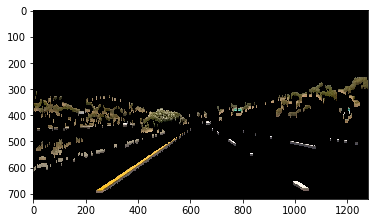

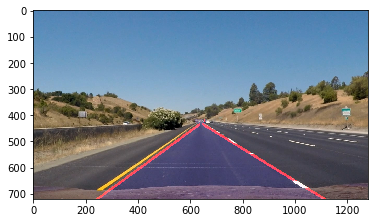

In [10]:
yellow_white_mask = color_mask(img)
plot_color_mask(img, yellow_white_mask)
res = detect_lines(img, yellow_white_mask)
plt.imshow(res)
plt.show()

## Warp Lane Lines
* The function takes in a set of source points and warps to a birds-eye view using a perspective transform

In [18]:
def warp_lane_lines(img, top_left, top_right, bot_left, bot_right):
    src = np.float32([top_left, top_right, bot_left, bot_right])
    dst = np.float32([[600, 500], [800, 500], [600, 700], [800, 700]])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

def plot_warped_lane_lines(img, color='virdis'):
    #TODO find corners automatically
    warped = warp_lane_lines(img, [520, 500], [760, 500], [280, 650], [960, 650])
    plt.imshow(warped, cmap=color)
    plt.show()

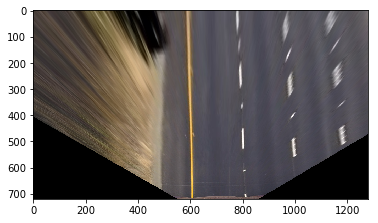

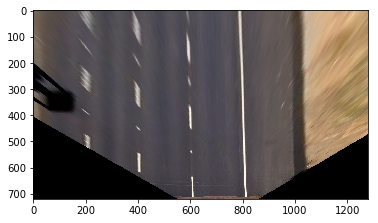

In [5]:
straight_img = mpimg.imread('./test_images/straight_lines1.jpg')
straight_img_2 = mpimg.imread('./test_images/straight_lines2.jpg')
plot_warped_lane_lines(straight_img)
plot_warped_lane_lines(straight_img_2)

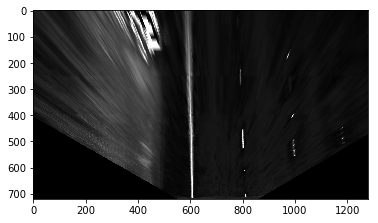

In [25]:
saturation = cv2.cvtColor(straight_img, cv2.COLOR_RGB2HLS)[:,:,2]
warped_saturation = plot_warped_lane_lines(saturation, color='gray')

In [48]:
def sobel_thresh(img, mag_thresh_min=0, mag_thresh_max=255, 
                     dir_thresh_min=0, dir_thresh_max=np.pi/2):
    '''Computes edges using Sobel edge detector'''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_mag = (255*sobel_mag / np.max(sobel_mag)).astype(np.uint8)
    binary_mag = np.zeros_like(sobel_mag)
    binary_mag[(sobel_mag >= mag_thresh_min) & (sobel_mag <= mag_thresh_max)] = 1
    
    plt.imshow(binary_mag, cmap='gray')
    plt.show()
    
    sobel_abs_x = np.sqrt(sobel_x**2)
    sobel_abs_y = np.sqrt(sobel_y**2)
    sobel_dir = np.arctan2(sobel_abs_y, sobel_abs_x)
    binary_dir = np.zeros_like(sobel_dir)
    binary_dir[(sobel_dir >= dir_thresh_min) & (sobel_dir <= dir_thresh_max)] = 1
    
    plt.imshow(binary_dir, cmap='gray')
    plt.show()
    
    combined = np.zeros_like(binary_dir)
    combined[[(binary_dir == 1) & (binary_mag == 1)]] = 1
    
    plt.imshow(combined, cmap='gray')
    plt.show()
    
    return combined

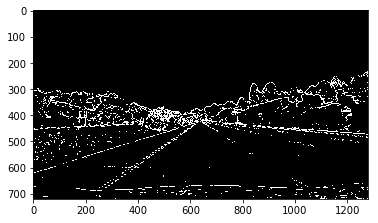

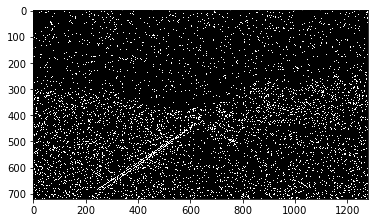

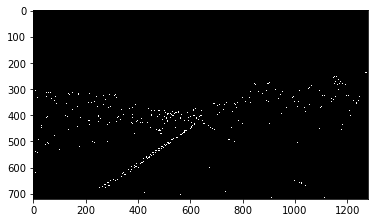

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [49]:
sobel_thresh(img, 30, 100, .9, 1.1)

In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines_challenge(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_challenge(line_img, lines)
    return line_img

def draw_lines_challenge(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #initialize line counts & points for each side
    l_count = r_count = 0
    rt_int = np.array([0.0,0.0])
    rb_int = np.array([0.0,0.0])
    lt_int = np.array([0.0,0.0])
    lb_int = np.array([0.0,0.0])
    
    #define the horizon and ground lines
    horizon = 0.58 #would like to detect this automatically
    top_left = (0, horizon*img.shape[0])
    top_right = (img.shape[1], horizon*img.shape[0])
    bot_left = (0,img.shape[0])
    bot_right=(img.shape[1],img.shape[0])
    
    #determine whether the line is on the right or left half and update the avg
    #position at which lines intersect the horizon and bottom
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope<-0.5:
                    #Left side since image is flipped
                    try:
                        l_count += 1
                        lt_int += intersection_point((x1,y1),(x2,y2),top_left,top_right)
                        lb_int += intersection_point((x1,y1),(x2,y2),bot_left,bot_right)
                    except ValueError:
                        print('Warning: Line parallel to horizon found')
                elif slope>0.5:
                    try:
                        r_count += 1
                        rt_int += intersection_point((x1,y1),(x2,y2),top_left,top_right)
                        rb_int += intersection_point((x1,y1),(x2,y2),bot_left,bot_right)
                    except ValueError:
                        print('Warning: Line parallel to horizon found')
        rt_int /= r_count
        rb_int /= r_count
        lt_int /= l_count
        lb_int /= l_count

        #draw lines for left and right side
        if r_count > 0:
            cv2.line(img, (int(rt_int[0]), int(rt_int[1])), 
                          (int(rb_int[0]), int(rb_int[1])), 
                          color, thickness)
        if l_count > 0:
            cv2.line(img, (int(lt_int[0]), int(lt_int[1])),
                          (int(lb_int[0]), int(lb_int[1])),
                          color, thickness)
        #fill in trapezoid between the two lines to make it look cooler
        if l_count > 0 and r_count > 0:
            #shift polygon over so it doesn't overlap lines
            pad = 4
            rt_int += np.array([-pad*thickness, 0])
            rb_int += np.array([-pad*thickness, 0])
            lt_int += np.array([pad*thickness, 0])
            lb_int += np.array([pad*thickness, 0])
            pts = np.array([rt_int, rb_int, lb_int, lt_int], np.int32)
            cv2.fillPoly(img, [pts], (0,0,31))
    else:
        print('Warning: No lines found.')

def intersection_point(p0,q0,p1,q1):
    '''Intersection of two lines from determinants'''
    v0 = np.array([p0,q0])
    v1 = np.array([p1,q1])
    a00 = np.array([[p0[0], 1], [q0[0], 1]])
    a01 = np.array([[p0[1], 1], [q0[1], 1]])
    a10 = np.array([[p1[0], 1], [q1[0], 1]])
    a11 = np.array([[p1[1], 1], [q1[1], 1]])
    
    denom = np.array([[np.linalg.det(a00), np.linalg.det(a01)],
                      [np.linalg.det(a10), np.linalg.det(a11)]])
    x_num = np.array([[np.linalg.det(v0), np.linalg.det(a00)],
                      [np.linalg.det(v1), np.linalg.det(a10)]])
    y_num = np.array([[np.linalg.det(v0), np.linalg.det(a01)],
                      [np.linalg.det(v1), np.linalg.det(a11)]])
    x = np.linalg.det(x_num)/np.linalg.det(denom)
    y = np.linalg.det(y_num)/np.linalg.det(denom)
    if np.isinf(x) or np.isinf(y):
        raise ValueError
    else:
        return np.array([x,y])